# Transform 2021 NLP demo by Anne Estoppey
### Friendly workflows with Natural Language Processing: well report summaries.

## Introduction
In this Jupyter Notebook, we will explore different aspects of NLP (Natural Language Processing). We will use well report summaries which are published by the NPD (Norwegian Petroleum Directorate), by requesting via an API. We will go through the different stages of text cleaning and formatting before moving on to NLP processing: tokenization, lemmatization and finally topic modeling.<br>

Level: intermediate. We expect participants to be familiar with mid level programming in python. Please see the requirements file and readme on the github repo.<br>

The well report summaries are available here: https://hotell.difi.no/?dataset=npd/wellbore/with-history (well report summaries). On the same page there is a link to API documentation (in Norwegian).<br> 

The following link should go to all data available from Norwegian Petroleum Directorate, in public domain: https://data.norge.no/datasets/4304aea1-53b1-47ed-beae-52bf4d3642f3 (link might get broken over time).<br>

#### Requirements - specific libraries for NLP
This notebook was run with Python version 3.7.4, from Jupyter lab. <br>

<b>spaCy: </b>free, open-source library for advanced Natural Language Processing (NLP) in Python.<br>
In this notebook we are using <b>spaCy version 3.0.5.</b><br>
<b>To install spaCy language model: (after you have installed the library) </b><br>
> pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz <br>

Github repo <a href="https://github.com/explosion/spacy-models"> here.</a><br>
More about spaCy <a href="https://spacy.io/usage/spacy-101"> here.</a><br>
More about the language model newest version <a href="https://spacy.io/usage/v3"> here.</a><br>
    
<b>gensim: </b> Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora (where 'corpus' or 'corpora' is collection of texts).<br>
More about gensim <a href="https://pypi.org/project/gensim/"> here.</a><br>
    
<b>pyLDAvis: </b>is designed to help users interpret the topics in a topic model that has been fit to a collection of text data.<br>
<b>Important: </b>You will need the following version of pyLDAvis for the topics visualisation: <b>pyLDAvis 2.1.2</b>.
<br>You'll need to install pyLDAvis 2.1.2 from PIP!<br>
More about pyLDAvis and topic modelling <a href="https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know"> here.</a><br>
#### How to fix blank maps and graph in jupyter lab!!
Check out link <a href="https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab"> here.</a><br>
To check if your jupyter lab plotly extension is up and running: > jupyter labextension list

#### References
Michael Dowling's repo: https://github.com/MichaelMDowling/TopicModel<br>
About evaluation of topic models, LDA: <a href="https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0"> this article in towardsdatascience. </a><br>
Research article about LDAvis: <a href="https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf"> here.</a><br>
<b>Books</b><br>
'Python Natural Language Processing Cookbook', Antić Zhenya, Packt Publishing, 2021<br>
'Practical Natural Language Processing', Sowmya Vajjala, Bodhisattwa Majumder, Anuj Gupta, and Harshit Surana, O'Reilly, 2020

---

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import re, os, operator
import collections 
import requests
import json
import warnings

import geopandas as gpd

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy

import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from wordcloud import WordCloud

In [2]:
warnings.filterwarnings('ignore')

#### API connection - check for status
Make a general get request, print out status code. 
Status code = 200 means API connection is up and running.

In [3]:
requests.get('https://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Well summaries
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [4]:
wells_summary = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-history?page=1')
json_wells_summary = wells_summary.json()
print(f'number of pages: {json_wells_summary["pages"]}')
print(f'number of rows:  {json_wells_summary["posts"]}')

number of pages: 19
number of rows:  1828


#### Let's go through all the pages and append all the rows in JSON dictionary, then in a pandas dataframe
Create a pandas dataframe from the json file

In [5]:
def get_all_data(url_dataset, df_out_name):
    '''getting number of pages,
    looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    wells_summary = requests.get(url_dataset)
    json_count_page = wells_summary.json()
    
    page = json_count_page['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_out_name = pd.DataFrame(all_data_list)
    return df_out_name

#### Getting all our well summaries into a dataframe

In [6]:
url_dataset ='https://hotell.difi.no/api/json/npd/wellbore/with-history'
df_out_name = 'df_all_summaries'

df_all_summaries = get_all_data(url_dataset, df_out_name)

In [7]:
df_all_summaries.shape

(1828, 5)

In [8]:
df_all_summaries.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  18.04.2021  
1  <p>The 1/2-2 well was drilled to evaluate the ...  18.04.2021  
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021  
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021  
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021

In [9]:
# check for duplicate wells!
def check_for_duplicates(df, column_name):
    boolean = df[column_name].duplicated().any()
    if boolean == True:
        pd.concat(g for _, g in df.groupby(column_name) if len(g) > 1)
    else:
        print("No duplicates!")
    return

In [10]:
check_for_duplicates(df_all_summaries, 'wlbName')

No duplicates!


#### Display a complete summary - we will need to clean all this html code!

In [11]:
# Display well summary (wlbHistory) 
df_all_summaries.iloc[1500]['wlbHistory']

'<p class=MsoBodyText><b><span lang=EN-GB>General</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>Well 6507/8-8 was drilled on the Ronaldo\nprospect ca 5 km south-east of the Heidrun Field in the Norwegian Sea. Ronaldo\nwas mapped as an eroded, elongated horst block with reservoir in the Early\nJurassic. The primary objective was to test the hydrocarbon potential in the\nEarly Jurassic Tilje and Åre Formations.</span></p>\n\n<p class=MsoBodyText><b><span lang=EN-GB>Operations and results</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>Wildcat well 6507/8-8 was drilled with\nthe semi-submersible installation Songa Delta. Due to boulders and shallow gas\nthe hole was spudded twice before 6507/8-8 was successfully spudded in the\nthird attempt on 26 February 2011 and drilled to TD at 2554 m in the Early\nJurassic Åre Formation, coal unit. No significant problem was encountered in\nthe operations. The well was drilled with Seawater down to 540 m, with\nKCl/polymer mud from 

#### Getting geolocation information for all wells - we will append this information to our well summary dataframe

In [12]:
wells_with_coordinates = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-coordinates?page=1')
json_wells_with_coordinates = wells_with_coordinates.json()
print(f'number of pages: {json_wells_with_coordinates["pages"]}')
print(f'number of rows:  {json_wells_with_coordinates["posts"]}')

number of pages: 85
number of rows:  8494


In [13]:
url_dataset = 'https://hotell.difi.no/api/json/npd/wellbore/with-coordinates'
df_out_name = 'df_all_with_coord'

df_all_with_coord = get_all_data(url_dataset, df_out_name)

In [14]:
df_all_with_coord.shape

(8494, 26)

In [15]:
df_all_with_coord.head()

wlbUtmZone  wlbWellType wlbEwDeg wlbEwCode wlbEntryDate wlbNsSec wlbEwMin  \
0         31  EXPLORATION        2         E   20.03.1989    15.07       28   
1         31  EXPLORATION        2         E   14.12.2005       32       29   
2         31        OTHER        2         E   09.05.2009    55.58       27   
3         31        OTHER        2         E   12.05.2009    56.95       27   
4         31        OTHER        2         E   12.05.2009    54.99       27   

  wlbEwSec wlbNsDecDeg wlbProductionLicence  ...   wlbEwUtm wlbNsMin  \
0     35.7   56.887519                  143  ...  468106.29       53   
1    47.66   56.992222               143 CS  ...  469410.10       59   
2     5.01   56.948772                  143  ...  466625.99       56   
3     7.69   56.949153                  143  ...  466671.62       56   
4     8.52   56.948608                  143  ...  466685.16       56   

  wlbWellboreName wlbContent            wlbDrillingOperator wlbEwDesDeg  \
0           1/2-1        OIL    Phillips Petroleum Norsk AS    2.476583   
1           1/2-2  OIL SHOWS     Paladin Resources Norge AS    2.496572   
2         1/2-U-1             ConocoPhillips Skandinavia AS    2.451392   
3         1/2-U-2             ConocoPhillips Skandinavia AS    2.452136   
4         1/2-U-3             ConocoPhillips Skandinavia AS    2.452367   

     wlbNsUtm wlbGeodeticDatum datesyncNPD wlbMainArea  
0  6305128.26             ED50  18.04.2021   NORTH SEA  
1  6316774.33             ED50  18.04.2021   NORTH SEA  
2  6311958.73             ED50  18.04.2021   NORTH SEA  
3  6312000.73             ED50  18.04.2021   NORTH SEA  
4  6311940.01             ED50  18.04.2021   NORTH SEA  

[5 rows x 26 columns]

In [16]:
# check for duplicate wells!
check_for_duplicates(df_all_with_coord, 'wlbWellboreName')

No duplicates!


#### Having a quick check on a map with our dataframe with coordinates

In [17]:
df_all_with_coord['wlbNsDecDeg'] = df_all_with_coord['wlbNsDecDeg'].astype(float).round(3)
df_all_with_coord['wlbEwDesDeg'] = df_all_with_coord['wlbEwDesDeg'].astype(float).round(3)

In [18]:
df_all_with_coord.dtypes

wlbUtmZone               object
wlbWellType              object
wlbEwDeg                 object
wlbEwCode                object
wlbEntryDate             object
wlbNsSec                 object
wlbEwMin                 object
wlbEwSec                 object
wlbNsDecDeg             float64
wlbProductionLicence     object
wlbNsDeg                 object
wlbNpdidWellbore         object
wlbPurposePlanned        object
wlbField                 object
wlbNsCode                object
wlbCompletionDate        object
wlbEwUtm                 object
wlbNsMin                 object
wlbWellboreName          object
wlbContent               object
wlbDrillingOperator      object
wlbEwDesDeg             float64
wlbNsUtm                 object
wlbGeodeticDatum         object
datesyncNPD              object
wlbMainArea              object
dtype: object

#### Drawing scatter map function

In [19]:
def drawScatterMap(dataframe, colorColumn, title):
    fig = px.scatter_mapbox(dataframe, 
                            lat="wlbNsDecDeg", lon="wlbEwDesDeg", 
                            color=colorColumn, 
                            width=1000, height=1000, 
                            # color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
                            color_discrete_sequence=px.colors.qualitative.D3,
                            hover_name='wlbWellboreName',
                            hover_data={'wlbMainArea' : False,
                                        'wlbNsDecDeg' : False,
                                        'wlbEwDesDeg' : False,
                                        'wlbContent'  : True,
                                        'wlbWellType' : True
                                       },
                            center={'lat':71, 'lon':20},
                            zoom=3, 
                            # mapbox_style="stamen-watercolor",
                            mapbox_style="carto-positron",
                            title=title
                            )


    return fig.show()

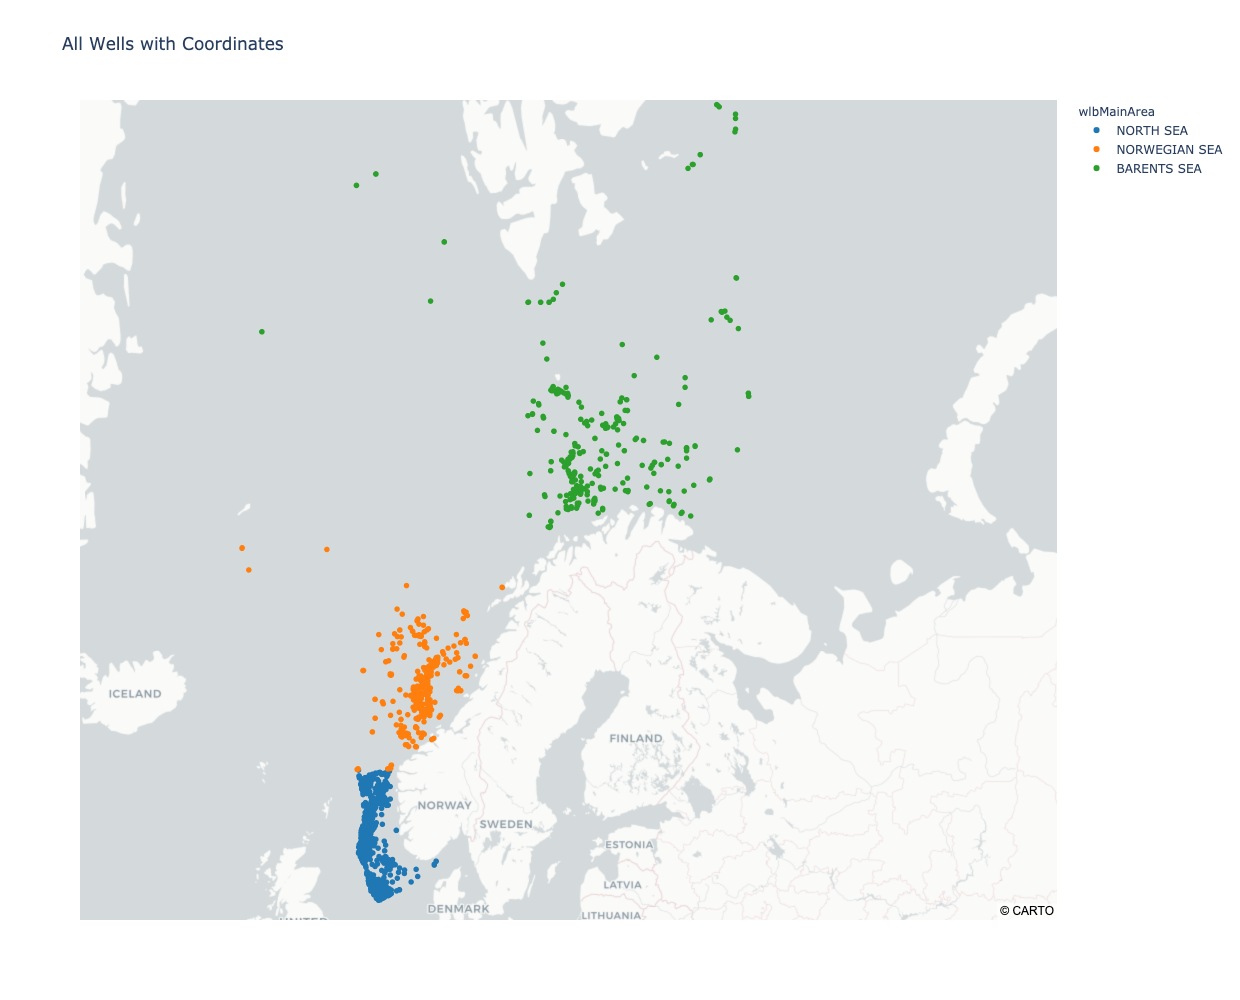

In [20]:
drawScatterMap(df_all_with_coord, 'wlbMainArea', 'All Wells with Coordinates')

In [21]:
df_all_with_coord.wlbMainArea.unique()

array(['NORTH SEA', 'NORWEGIAN SEA', 'BARENTS SEA'], dtype=object)

#### Merging df_all_with_coord together with df_all_summaries to get coordinates in the summary df

In [22]:
df_summaries_coord = pd.merge(df_all_summaries, 
                              df_all_with_coord[['wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm',
                                                 'wlbWellboreName', 'wlbContent', 'wlbMainArea', 'wlbDrillingOperator', 'wlbWellType']], 
                              how='left',
                              left_on='wlbName', 
                              right_on='wlbWellboreName')

In [23]:
df_summaries_coord.shape

(1828, 14)

In [24]:
df_summaries_coord.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  wlbEwDesDeg  \
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  18.04.2021        2.477   
1  <p>The 1/2-2 well was drilled to evaluate the ...  18.04.2021        2.497   
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021        2.851   
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021        2.706   
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021        2.706   

   wlbNsDecDeg   wlbEwUtm    wlbNsUtm wlbWellboreName wlbContent wlbMainArea  \
0       56.888  468106.29  6305128.26           1/2-1        OIL   NORTH SEA   
1       56.992  469410.10  6316774.33           1/2-2  OIL SHOWS   NORTH SEA   
2       56.856  490936.87  6301488.86           1/3-1        GAS   NORTH SEA   
3       56.928  482089.29  6309521.94          1/3-10    OIL/GAS   NORTH SEA   
4       56.928  482089.29  6309521.94        1/3-10 A    OIL/GAS   NORTH SEA   

           wlbDrillingOperator  wlbWellType  
0  Phillips Petroleum Norsk AS  EXPLORATION  
1   Paladin Resources Norge AS  EXPLORATION  
2             A/S Norske Shell  EXPLORATION  
3            DONG E&P Norge AS  EXPLORATION  
4            DONG E&P Norge AS  EXPLORATION

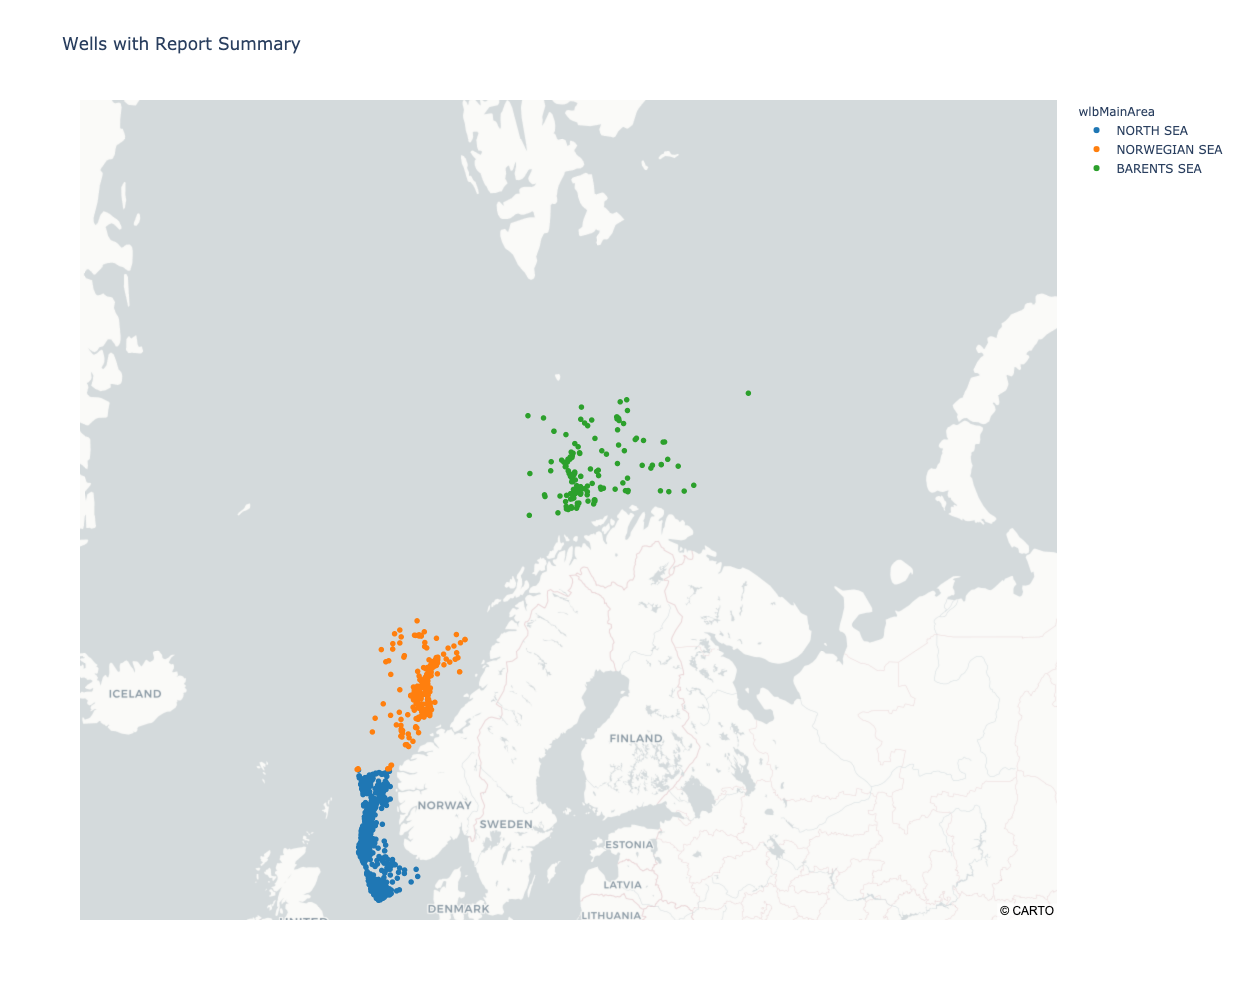

In [25]:
drawScatterMap(df_summaries_coord, 'wlbMainArea', 'Wells with Report Summary')

---

#### Starting cleaning of well summaries in the dataframe

In [26]:
# creating a copy of dataframe
df_summaries_coord_clean = df_summaries_coord.copy()
df_summaries_coord_clean.shape

(1828, 14)

#### We start with some basic text cleaning (removing html and new line tags, and replacing bad quotation tags).
We create a new attribute 'wlbHistory_clean' with the resulting clean texts.

In [27]:
def cleanhtml():
    # remove html tags
    cleanr = re.compile('<.*?>')
    
    rows = df_summaries_coord_clean['wlbHistory']
    listcleantext = []
    for r in rows:
        cleantext = re.sub(cleanr, '', r)
        
        # replace new line \n with empty space
        cleantext = cleantext.replace('\n', ' ')
        
        # replace &quot; with single quote
        cleantext = cleantext.replace('&quot;', "''")
        
        # replace &nbsp with empty space
        cleantext = cleantext.replace('&nbsp', ' ')
        
        listcleantext.append(cleantext)
    df_summaries_coord_clean['wlbHistory_clean'] = listcleantext
    return

In [28]:
cleanhtml()

In [29]:
df_summaries_coord_clean.shape

(1828, 15)

In [30]:
df_summaries_coord_clean.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  wlbEwDesDeg  \
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  18.04.2021        2.477   
1  <p>The 1/2-2 well was drilled to evaluate the ...  18.04.2021        2.497   
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021        2.851   
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021        2.706   
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  18.04.2021        2.706   

   wlbNsDecDeg   wlbEwUtm    wlbNsUtm wlbWellboreName wlbContent wlbMainArea  \
0       56.888  468106.29  6305128.26           1/2-1        OIL   NORTH SEA   
1       56.992  469410.10  6316774.33           1/2-2  OIL SHOWS   NORTH SEA   
2       56.856  490936.87  6301488.86           1/3-1        GAS   NORTH SEA   
3       56.928  482089.29  6309521.94          1/3-10    OIL/GAS   NORTH SEA   
4       56.928  482089.29  6309521.94        1/3-10 A    OIL/GAS   NORTH SEA   

           wlbDrillingOperator  wlbWellType  \
0  Phillips Petroleum Norsk AS  EXPLORATION   
1   Paladin Resources Norge AS  EXPLORATION   
2             A/S Norske Shell  EXPLORATION   
3            DONG E&P Norge AS  EXPLORATION   
4            DONG E&P Norge AS  EXPLORATION   

                                    wlbHistory_clean  
0  General  Well 1/2-1 is located in the Central ...  
1  The 1/2-2 well was drilled to evaluate the pro...  
2  General  Well 1/3-1 was drilled on the crest o...  
3  General  Well 1/3-10 is located on the Hidra H...  
4  General  Well 1/3-10 A is located on the Hidra...

In [31]:
rawtext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory']
rawtext_sample

"<p class=MsoBodyText><b><span lang=EN-GB>General</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>Well 1/3-1 was drilled on the crest of a\nsalt-induced anticline on the Hidra High in the North Sea. The purpose of the\nwell was to investigate Tertiary and Mesozoic sequences down to top salt.</span></p>\n\n<p class=MsoBodyText><span lang=EN-GB>The well is Type Well for the Våle, Hidra,\nHod, and Tor Formations, and Reference Well for the Vidar, Ekofisk and Blodøks Formations.</span></p>\n\n<p class=MsoBodyText><b><span lang=EN-GB>Operations and results</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>Well 1/3-1 was spudded with the four leg\njack-up installation Orion on 6 July 1968 and drilled to TD at 4877 m in the\nPermian Zechstein Group. From the deviation survey it is seen that the well\nstarts to deviate significantly at 4037 m (8 deg deviation), and at TD the\ndeviation is 18 deg. This will correspond to a TVD RKB that is ca 25 m less\nthan MD RKB.</span><span lan

In [32]:
cleantext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory_clean']
cleantext_sample

"General  Well 1/3-1 was drilled on the crest of a salt-induced anticline on the Hidra High in the North Sea. The purpose of the well was to investigate Tertiary and Mesozoic sequences down to top salt.  The well is Type Well for the Våle, Hidra, Hod, and Tor Formations, and Reference Well for the Vidar, Ekofisk and Blodøks Formations.  Operations and results  Well 1/3-1 was spudded with the four leg jack-up installation Orion on 6 July 1968 and drilled to TD at 4877 m in the Permian Zechstein Group. From the deviation survey it is seen that the well starts to deviate significantly at 4037 m (8 deg deviation), and at TD the deviation is 18 deg. This will correspond to a TVD RKB that is ca 25 m less than MD RKB.Several drilling problems occurred during the drilling operations of well 1/3-1. While drilling the 17 1/2'' hole for the 20'' casing, circulation losses started at 220 m (720') and became total at 238 m (781'). While drilling on with sea water, without returns, the pipe stuck. T

---

### Pre-processing for NLP

We continue with our dataframe 'df_summaries_coord_clean'

#### We calculate the average length (number of words) for all summaries in dataframe wlbHistory_clean:

In [33]:
print('Average wlbHistory length: ' + str(df_summaries_coord_clean["wlbHistory_clean"].str.split().str.len().mean()))

Average wlbHistory length: 407.8446389496718


#### We can enter a well name, and its summary will be grabbed for cleaning and then displaying in a wordcloud.

In [34]:
wellname = input('Please enter well name: ')

try:
    wi1 = next(iter(df_summaries_coord_clean[df_summaries_coord_clean['wlbName']== wellname].index), 'no match')
    wi2 = wi1 + 1
    # print(wi1)
    # print(wi2)
except:
    print('Please enter well name in proper format. Examples: 1/3-5, 1/3-9 S, 6406/2-1')

Please enter well name:  1/3-1


#### We create a list of strings, where each well summary is a string.
At this stage we decide to handle only the well report summaries, and will not continue with the geospatial aspect of the dataframe.<br>
Therefore we group our well report summaries in a list.

In [35]:
wlbHistory_clean_to_list = df_summaries_coord_clean["wlbHistory_clean"].values.tolist()

#### Let's have a look at our well summary (wi1 and wi2 are the index values for a given well in dataframe)

In [36]:
print(wlbHistory_clean_to_list[wi1:wi2])

["General  Well 1/3-1 was drilled on the crest of a salt-induced anticline on the Hidra High in the North Sea. The purpose of the well was to investigate Tertiary and Mesozoic sequences down to top salt.  The well is Type Well for the Våle, Hidra, Hod, and Tor Formations, and Reference Well for the Vidar, Ekofisk and Blodøks Formations.  Operations and results  Well 1/3-1 was spudded with the four leg jack-up installation Orion on 6 July 1968 and drilled to TD at 4877 m in the Permian Zechstein Group. From the deviation survey it is seen that the well starts to deviate significantly at 4037 m (8 deg deviation), and at TD the deviation is 18 deg. This will correspond to a TVD RKB that is ca 25 m less than MD RKB.Several drilling problems occurred during the drilling operations of well 1/3-1. While drilling the 17 1/2'' hole for the 20'' casing, circulation losses started at 220 m (720') and became total at 238 m (781'). While drilling on with sea water, without returns, the pipe stuck. 

#### We use regex (re) to do some more cleaning

In [37]:
wlbHistory_clean_to_list2 = []

for sentence in range(0, len(wlbHistory_clean_to_list)):
    
    # Remove single characters from the start
    wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove all the special characters
    wlbHistory_ = re.sub(r'\W', ' ', wlbHistory_)

    # Substituting multiple spaces with single space
    wlbHistory_ = re.sub(r'\s+', ' ', wlbHistory_, flags=re.I)

    wlbHistory_clean_to_list2.append(wlbHistory_)

In [38]:
print(wlbHistory_clean_to_list2[wi1:wi2])

['General Well 1 3 1 was drilled on the crest of a salt induced anticline on the Hidra High in the North Sea The purpose of the well was to investigate Tertiary and Mesozoic sequences down to top salt The well is Type Well for the Våle Hidra Hod and Tor Formations and Reference Well for the Vidar Ekofisk and Blodøks Formations Operations and results Well 1 3 1 was spudded with the four leg jack up installation Orion on 6 July 1968 and drilled to TD at 4877 m in the Permian Zechstein Group From the deviation survey it is seen that the well starts to deviate significantly at 4037 m 8 deg deviation and at TD the deviation is 18 deg This will correspond to a TVD RKB that is ca 25 m less than MD RKB Several drilling problems occurred during the drilling operations of well 1 3 1 While drilling the 17 1 2 hole for the 20 casing circulation losses started at 220 m 720 and became total at 238 m 781 While drilling on with sea water without returns the pipe stuck The lost circulation zone eventua

#### We change (transform) strings to bag-of-words. 

In [39]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

bag_of_words = list(sent_to_words(wlbHistory_clean_to_list2))

print(bag_of_words[wi1:wi2])

[['general', 'well', 'was', 'drilled', 'on', 'the', 'crest', 'of', 'salt', 'induced', 'anticline', 'on', 'the', 'hidra', 'high', 'in', 'the', 'north', 'sea', 'the', 'purpose', 'of', 'the', 'well', 'was', 'to', 'investigate', 'tertiary', 'and', 'mesozoic', 'sequences', 'down', 'to', 'top', 'salt', 'the', 'well', 'is', 'type', 'well', 'for', 'the', 'vale', 'hidra', 'hod', 'and', 'tor', 'formations', 'and', 'reference', 'well', 'for', 'the', 'vidar', 'ekofisk', 'and', 'blodøks', 'formations', 'operations', 'and', 'results', 'well', 'was', 'spudded', 'with', 'the', 'four', 'leg', 'jack', 'up', 'installation', 'orion', 'on', 'july', 'and', 'drilled', 'to', 'td', 'at', 'in', 'the', 'permian', 'zechstein', 'group', 'from', 'the', 'deviation', 'survey', 'it', 'is', 'seen', 'that', 'the', 'well', 'starts', 'to', 'deviate', 'significantly', 'at', 'deg', 'deviation', 'and', 'at', 'td', 'the', 'deviation', 'is', 'deg', 'this', 'will', 'correspond', 'to', 'tvd', 'rkb', 'that', 'is', 'ca', 'less', '

#### Removing stop words from bag-of-words

In [40]:
stop_words = stopwords.words('english')
stop_words.extend(['formation', 'formations', 'group', 'core', 'sm', 'well', 'zone', 'drilled', 'target', 
                   'reservoir', 'primary', 'hole', 'mud', 'cut'])
# --> we can add extra words here that we want to remove from the bag of words

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bag_of_words_no_stop = remove_stopwords(bag_of_words)

In [41]:
print(bag_of_words_no_stop[wi1:wi2])

[['general', 'crest', 'salt', 'induced', 'anticline', 'hidra', 'high', 'north', 'sea', 'purpose', 'investigate', 'tertiary', 'mesozoic', 'sequences', 'top', 'salt', 'type', 'vale', 'hidra', 'hod', 'tor', 'reference', 'vidar', 'ekofisk', 'blodøks', 'operations', 'results', 'spudded', 'four', 'leg', 'jack', 'installation', 'orion', 'july', 'td', 'permian', 'zechstein', 'deviation', 'survey', 'seen', 'starts', 'deviate', 'significantly', 'deg', 'deviation', 'td', 'deviation', 'deg', 'correspond', 'tvd', 'rkb', 'ca', 'less', 'md', 'rkb', 'several', 'drilling', 'problems', 'occurred', 'drilling', 'operations', 'drilling', 'casing', 'circulation', 'losses', 'started', 'became', 'total', 'drilling', 'sea', 'water', 'without', 'returns', 'pipe', 'stuck', 'lost', 'circulation', 'eventually', 'sealed', 'cement', 'plug', 'tertiary', 'plastic', 'clays', 'problems', 'included', 'tight', 'conditions', 'bit', 'balling', 'difficulties', 'lowering', 'logging', 'tools', 'weight', 'raised', 'ppg', 'ppg',

In [42]:
len(bag_of_words_no_stop) # --> this should still return the same length of our original 'df_all_summaries' dataframe :)

1828

---

### Creating WordCloud

#### We first flatten 'bag_of_words_no_stop[wi1:wi2]' into a non nested list

In [43]:
t = bag_of_words_no_stop[wi1:wi2]
flat_list = []
for sublist in t:
    for item in sublist:
        flat_list.append(item)

In [44]:
print(flat_list)

['general', 'crest', 'salt', 'induced', 'anticline', 'hidra', 'high', 'north', 'sea', 'purpose', 'investigate', 'tertiary', 'mesozoic', 'sequences', 'top', 'salt', 'type', 'vale', 'hidra', 'hod', 'tor', 'reference', 'vidar', 'ekofisk', 'blodøks', 'operations', 'results', 'spudded', 'four', 'leg', 'jack', 'installation', 'orion', 'july', 'td', 'permian', 'zechstein', 'deviation', 'survey', 'seen', 'starts', 'deviate', 'significantly', 'deg', 'deviation', 'td', 'deviation', 'deg', 'correspond', 'tvd', 'rkb', 'ca', 'less', 'md', 'rkb', 'several', 'drilling', 'problems', 'occurred', 'drilling', 'operations', 'drilling', 'casing', 'circulation', 'losses', 'started', 'became', 'total', 'drilling', 'sea', 'water', 'without', 'returns', 'pipe', 'stuck', 'lost', 'circulation', 'eventually', 'sealed', 'cement', 'plug', 'tertiary', 'plastic', 'clays', 'problems', 'included', 'tight', 'conditions', 'bit', 'balling', 'difficulties', 'lowering', 'logging', 'tools', 'weight', 'raised', 'ppg', 'ppg', 

In [45]:
len(flat_list)

296

#### Converting our list to a long string of words separated by space, in order to create the WordCloud

In [46]:
flat_list_to_string = ''
flat_list_to_string += " ".join(flat_list)+" "

In [47]:
print(flat_list_to_string)

general crest salt induced anticline hidra high north sea purpose investigate tertiary mesozoic sequences top salt type vale hidra hod tor reference vidar ekofisk blodøks operations results spudded four leg jack installation orion july td permian zechstein deviation survey seen starts deviate significantly deg deviation td deviation deg correspond tvd rkb ca less md rkb several drilling problems occurred drilling operations drilling casing circulation losses started became total drilling sea water without returns pipe stuck lost circulation eventually sealed cement plug tertiary plastic clays problems included tight conditions bit balling difficulties lowering logging tools weight raised ppg ppg stabilize bit twisted retrieved second fishing run hydrocarbon bearing encountered became gas degasser overloaded circulation lost probably higher cement plug needed combat lost circulation problems decided set casing circulation lost running casing cemented two stages drilling continued bit ar

In [48]:
# define the WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string)

In [49]:
def WordCloud_plot(wordcloud, wellname):
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(label="WordCloud for Well " + wellname + "\n\n",
             fontsize = 20,
             color = "black")

    plt.show()
    return

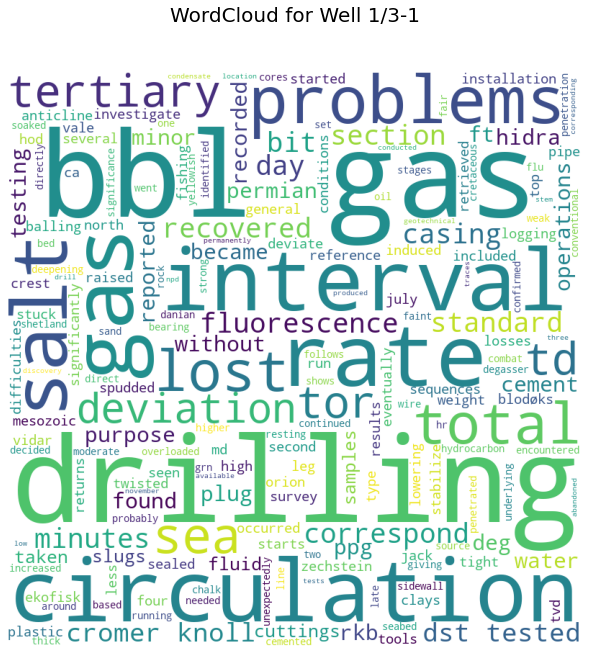

In [50]:
WordCloud_plot(wordcloud, wellname)

In [51]:
# %reset

---

## Processing all summaries
We are going to use 'bag_of_words_no_stop' which we created above. It's a list of list, where every element is a bag of word for each summary.

In [52]:
type(bag_of_words_no_stop)

list

#### A few words about tokenization, lemmatization/stemming and POS

<b>Corpus: </b>collection of all your texts or documents (here our well report summaries)<br>

Note that we are going to use interchangeably 'token', 'word', and 'term'.<br>

<b>Tokenization: </b>splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.<br>

<b>Lemmatization vs stemming: </b>Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.<br>
For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care’, whereas, stemming would cutoff the ‘ing’ part and convert it to car.<br>

‘Caring’ -> Lemmatization -> ‘Care’<br>
‘Caring’ -> Stemming -> ‘Car’<br>

Knowing this, I would say that Lemmatization is a more 'correct' way of treating text. Stemming seems to 'oversimplify'. OTOH, Stemming could be a way to process large amount of texts more quickly. Possibly one way to avoid word ambiguity with stemming would be to use bigrams/trigrams (association of two or three words together in order to give context). In this notebook we chose Lemmatization, since we are not using GPU (working with bigrams/trigrams is processor intensive).<br>

<b>Part Of Speach (POS): </b>also called grammatical tagging is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its definition and its context.<br>

<img src="../images/POS_online_example.jpg" width=700 >

#### A few words about spaCy
spaCy is a pretrained language model. In this notebook we are going to use language model 'en_core_web_sm-3.0.0'.<br>

<b>We asked GPT-3 those questions. Here are some short answers!</b><br>
Q: What is a pretrained language model?<br>
GPT-3: A pretrained language model is a language model that has been trained on a large amount of data.<br>
Q: What is a language model?<br>
GPT-3: A language model is a statistical model that estimates the probability of a word given a context.<br>
Q: In which context do you use a language model?<br>
GPT-3: A language model is used in the fields of machine translation, speech recognition, and information retrieval.<br>
(answers generated in GPT-3 Playground area on beta.open.ai)

#### Please check in the introduction at the top of this notebook how to install spaCy library

In [53]:
# path to our spaCy language model
path_spacy_model = '/anaconda3/envs/python37/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-3.0.0'

# loading the model
nlp = spacy.load(path_spacy_model, disable=['parser', 'ner'])

In [54]:
type(nlp)

spacy.lang.en.English

#### Reducing the term count
We have already removed our stop words.<br>
The lemmatization will allow us to select a specific type of word, for instance 'NOUN'

In [55]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))    # remember: nlp is defined in our previous cell, it is the spaCey language model
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [56]:
bag_of_words_no_stop_lemma = lemmatization(bag_of_words_no_stop, allowed_postags=['NOUN'])

In [57]:
print(bag_of_words_no_stop_lemma[wi1])

['crest', 'salt', 'anticline', 'hidra', 'north', 'sea', 'purpose', 'sequence', 'salt', 'type', 'vale', 'hidra', 'hod', 'tor', 'reference', 'vidar', 'ekofisk', 'blodøks', 'operation', 'result', 'leg', 'jack', 'installation', 'orion', 'july', 'zechstein', 'deviation', 'survey', 'start', 'deviation', 'deviation', 'rkb', 'drilling', 'problem', 'operation', 'drilling', 'casing', 'circulation', 'loss', 'drilling', 'sea', 'water', 'return', 'pipe', 'circulation', 'cement', 'plug', 'plastic', 'clay', 'problem', 'condition', 'bit', 'difficulty', 'tool', 'weight', 'ppg', 'ppg', 'bit', 'fishing', 'run', 'hydrocarbon', 'bearing', 'gas', 'degasser', 'circulation', 'cement', 'plug', 'combat', 'circulation', 'problem', 'casing', 'circulation', 'running', 'casing', 'stage', 'bit', 'salt', 'penetration', 'rate', 'hr', 'problem', 'water', 'sand', 'significance', 'section', 'chalk', 'section', 'shetland', 'cromer', 'knoll', 'salt', 'gas', 'testing', 'tor', 'source', 'rock', 'section', 'show', 'interval',

In [58]:
len(bag_of_words_no_stop_lemma[wi1])

165

---

#### Let's try to build wordcloud on the lemmatized summary with only Nouns.

In [59]:
flat_list_to_string_lemma = ''
flat_list_to_string_lemma += " ".join(bag_of_words_no_stop_lemma[wi1])+" "

In [60]:
flat_list_to_string_lemma

'crest salt anticline hidra north sea purpose sequence salt type vale hidra hod tor reference vidar ekofisk blodøks operation result leg jack installation orion july zechstein deviation survey start deviation deviation rkb drilling problem operation drilling casing circulation loss drilling sea water return pipe circulation cement plug plastic clay problem condition bit difficulty tool weight ppg ppg bit fishing run hydrocarbon bearing gas degasser circulation cement plug combat circulation problem casing circulation running casing stage bit salt penetration rate hr problem water sand significance section chalk section shetland cromer knoll salt gas testing tor source rock section show interval fluorescence sidewall core interval fluorescence cutting cutting oil yellowish grn flu ft wire line fluid sample sea bed seabed purpose location sample npd gas discovery drill stem test fluid rate interval cromer knoll bbl gas minute rate bbl gas day dst interval cromer knoll bbl gas trace slug 

In [61]:
# redefine the WordCloud for lemmatized summary
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string_lemma)

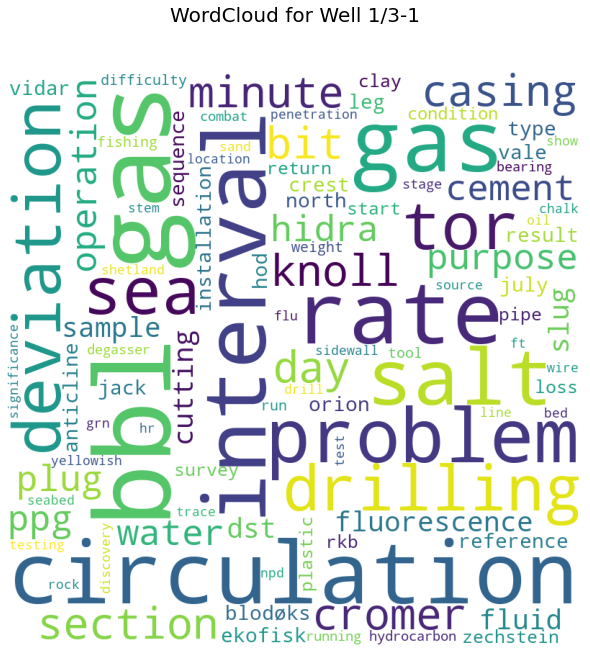

In [62]:
WordCloud_plot(wordcloud, wellname)

---

#### Inspect most frequest terms from our lemmatized bag of words

In [63]:
def detoken(texts):
    """detokenizer"""
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join(s for s in sent))
    return texts_out

bag_of_words_no_stop_lemma_test = detoken(bag_of_words_no_stop_lemma)    # reassembling lists of tokens into continuous lists of strings

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(bag_of_words_no_stop_lemma_test)
freq = np.ravel(X.sum(axis=0)) 

vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq))

# Save all terms as CSV file to inspect all

with open('term_dict.csv', 'w', encoding='utf-8') as f:
    for key in fdist.keys():
        f.write("%s,%s\n"%(key,fdist[key]))

In [64]:
# Reading term_dict csv file into a pandas and sort the df by frequencies 
# to see which words are very frequent (ubiquitous).
df_term_dict = pd.read_csv('term_dict.csv', names=['token', 'frequency'])
df_term_dict.sort_values('frequency', ascending= False, inplace=True)

In [65]:
df_term_dict.head(10)

token  frequency
2371          oil       7636
1340          gas       5764
3428         test       3992
3741        water       3987
2950    sandstone       3549
2940       sample       2682
1619  hydrocarbon       2668
2393    operation       2555
2944         sand       2509
1726     interval       2484

#### Create a document-term-matrix (DTM) --> this is going to be used in the topic modelling function below

In [66]:
# Create Dictionary
id2word = Dictionary(bag_of_words_no_stop_lemma)
print("Length of initial dictionary is: ", (len(id2word)))

### id2word.filter_extremes(no_below=5, no_above=1)  # 'no_above=1': tokens appearing in all documents (100% of the corpus) will not be removed
id2word.filter_extremes(no_below=5, no_above=0.5)      # 'no_below=5': tokens appearing less that 5 times in all documents will be removed
                            
print("Length of reduced dictionary is: ", (len(id2word)))

# Create Corpus
texts = bag_of_words_no_stop_lemma

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
print(id2word)

Length of initial dictionary is:  3843
Length of reduced dictionary is:  1437
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 3), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 2), (53, 1)]]
Dictionary(1437 unique tokens: ['analysis', 'api', 'attempt', 'barrier', 'bearing']...)


<b>Note about method 'filter_extreme': </b>'no_above' parametre is the way to remove tokens which are too ubiquitous: by appearing in all (or almost all) well summaries, these tokens do not bring any particular information (no_above=1). 'No_above=0.5' means that tokens which appear in more that 50% of the summaries will be dropped.<br>
Increasing the value for 'no_above' also increases the <b>perplexity</b> value: the model will have more difficulty to generate the different topics (topics will overlap significantly).

---

## Topic modeling
<b>What is Topic modeling?</b><br>
GPT-3: Uncovering the hidden or latent topics across a set of documents.<br>
A given number of themes (or topics) will be generated by grouping words which have an apparent connected meaning.<br>
Topic modeling has similarities to clustering. But topic models can also be used for understanding, exploring, and visualizing a collection of texts.<br>

#### We are going to calculate coherence values for various numbers of topics. In this way we can select which number of topics seems the most suitable.

In [67]:
# Function to Calculate topic coherence for topic models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    alpha = [0.1, 1, 10]
    random_seed = [32, 64]
    coherence_values = []
    model_list = []
    output_list = []
    for num_topics in range(start, limit, step):
        for a in alpha:
            for r in random_seed:
                model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=r, alpha=a, workers=3)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
                model_output ={'alpha': a, 'random_seed': r, 'coherence': coherencemodel.get_coherence(), 'num_topics': num_topics}
                output_list.append(model_output)
              
    return model_list, coherence_values, output_list

In [68]:
model_list, coherence_values, output_list = compute_coherence_values(dictionary=id2word,
                                                                     corpus=corpus, texts=texts, start=4, limit=10, step=1)

#### Inspect the models - here we see that the models tries different numbers of topics - we'll try the number of topics with highest coherence
GPT-3: A coherency score of 1 indicates that the documents are completely coherent, meaning they are about the same topic. A coherency score of 0 indicates that the documents are completely incoherent, meaning they are about completely different topics.

In [69]:
output_list_descending = sorted(output_list, key=lambda d: d['coherence'], reverse=True)
pprint(output_list_descending)

[{'alpha': 0.1,
  'coherence': 0.31982452058688376,
  'num_topics': 9,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3152641639667035,
  'num_topics': 5,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3143479180799366,
  'num_topics': 7,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.31408526341417164,
  'num_topics': 9,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.31271678382619594,
  'num_topics': 7,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.31226267264264285,
  'num_topics': 8,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.31143829690243663,
  'num_topics': 4,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.311192254192843,
  'num_topics': 9,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3107154695465695,
  'num_topics': 6,
  'random_seed': 32},
 {'alpha': 0.1,
  'coherence': 0.3106142473599945,
  'num_topics': 7,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.3096928112586115,
  'num_topics': 8,
  'random_seed'

#### Build LDA model - here we generate our topics
GPT-3: LDA stands for Latent Dirichlet Allocation, a topic model for discovering the topics in a collection of documents.<br>
GPT-3: The main characteristics of LDA are that it does not assume a fixed number of topics and it works well with very large collections of documents.

In [70]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=10,
                                           per_word_topics=True)

#### Print the most frequent words in our topics (the attribution of the group number is random)

In [71]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.057*"day" + 0.055*"dst" + 0.034*"temperature" + 0.027*"gravity" + '
  '0.025*"flow" + 0.024*"rft" + 0.021*"density" + 0.021*"depth" + '
  '0.021*"condensate" + 0.019*"cm"'),
 (1,
  '0.036*"prospect" + 0.027*"stø" + 0.023*"quality" + 0.020*"snadd" + '
  '0.019*"statfjord" + 0.019*"pressure" + 0.019*"pilot" + 0.017*"brent" + '
  '0.016*"property" + 0.015*"field"'),
 (2,
  '0.042*"section" + 0.038*"drilling" + 0.035*"sand" + 0.027*"seawater" + '
  '0.024*"log" + 0.017*"jurassic" + 0.017*"salt" + 0.017*"porosity" + '
  '0.015*"bryne" + 0.014*"basin"'),
 (3,
  '0.041*"pressure" + 0.034*"contact" + 0.028*"structure" + 0.027*"sidetrack" '
  '+ 0.025*"appraisal" + 0.022*"field" + 0.018*"east" + 0.017*"gradient" + '
  '0.017*"datum" + 0.016*"wire"'),
 (4,
  '0.035*"rock" + 0.029*"sand" + 0.029*"shale" + 0.024*"sequence" + '
  '0.023*"age" + 0.022*"source" + 0.021*"part" + 0.020*"claystone" + '
  '0.017*"analysis" + 0.017*"jurassic"')]


#### Remember Perplexity that we saw about 'filter_extremes()' method? We are going to calculate it below.
GPT-3: Perplexity is a measure of how well a topic model represents a collection of documents.<br>


In [72]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.250859192424242


#### Compute Coherence Score
GPT-3: A coherency score of 1 indicates that the documents are completely coherent, meaning they are about the same topic. A coherency score of 0 indicates that the documents are completely incoherent, meaning they are about completely different topics.

In [73]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=bag_of_words_no_stop_lemma, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42601904759975273


#### Visualize the topics - note: here topics are numbered from largest group to smallest group (% of tokens)

In [74]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.067763  0.321948       1        1  21.011406
3      0.205760 -0.068893       2        1  20.202137
2     -0.184404  0.016651       3        1  19.915125
4     -0.249810 -0.094443       4        1  19.815491
1      0.160691 -0.175263       5        1  19.055847, topic_info=    Category         Freq          Term        Total  loglift  logprob
14   Default  1357.000000           day  1357.000000  30.0000  30.0000
95   Default  1307.000000           dst  1307.000000  29.0000  29.0000
51   Default   824.000000   temperature   824.000000  28.0000  28.0000
118  Default   833.000000          rock   833.000000  27.0000  27.0000
74   Default   907.000000      prospect   907.000000  26.0000  26.0000
..       ...          ...           ...          ...      ...      ...
152   Topic5   229.952438         level   456.940247   0.9711  -4.5477
71    Topic5   276.278046          part  1159.311035   0.2236  -4.3642
19    Topic5   197.413483  fluorescence   495.372589   0.7378  -4.7003
443   Topic5   188.964005     reservoir   321.932251   1.1250  -4.7441
46    Topic5   200.071213      seawater  1141.792969  -0.0839  -4.6869

[315 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
257       1  0.028382   age
257       3  0.075687   age
257       4  0.816784   age
257       5  0.080417   age
138       1  0.999228   air
...     ...       ...   ...
305       1  0.663595  zone
305       2  0.078490  zone
305       3  0.199792  zone
305       4  0.042813  zone
305       5  0.014271  zone

[575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

Circle 1: well test<br>
Circle 2: fluid/contact<br>
Circle 3: ?<br>
Circle 4: stratigraphy<br>
Circle 5: explo<br>

<b>About lambda parametre:</b><br>

 - Values of lambda that are very close to <b>zero</b> will show terms that are <b>more specific for a chosen topic</b>. Meaning that you will see terms that are "important" for that specific topic but not necessarily "important" for the whole corpus.

 - Values of lambda that are very close to one will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus.


lambda = 0: very specific words (words which are very specific to a given topic. In some cases the topic will contain exclusively that word).<br>
lambda = 1: generic words (words which appear in a given topic but are also common in the rest of the corpus.<br>

<b>Check out <a href="https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf"> article page 64 and 68!</a></b> for further explanations about lambda.<br>

<b>What are PC1 and PC2?</b><br>
PCA (Principal Component Analysis) assumes that the directions with the largest variances are the most 'important' (i.e, the most principal). The PC1 axis is the first principal direction along which the samples show the largest variation. The PC2 axis is the second most important direction and it is orthogonal to the PC1 axis.<br>
GPT-3: Principal Component Analysis is a statistical method for reducing the dimensionality of data.

---

### Conclusions
As we noticed with the result of the topic modeling analysis and visualisation, it's not always easy to put a label on the different topics. In our case, it would help to have more domain knowledge, especially someone with well drilling experience in the North Sea. This allows us to say that in every Data Science team, a domain expert should be involved.<br>

Further analysis:
 - introduce the notion of time: are topics changing through the years? how?
 - spend more time experimenting with the different parametres, especially when working with the gensim library.
 - can we track back for each well, to which main topic they belong? (then be able to draw the topics on the map?)
 - could we have this modeling in production? which solution to choose for this purpose? 


---